# This notebook is a continuation for  validating the results of Gaztañaga and Fosalba

### The first sections is going to be destinated for  making the mask for CMB analysis. For our analysis we shall use the cleaing  method of reference SMICA CMB map (Fosalba & Gaztañaga, 2021)

In [7]:
# Importing libraries
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
# Import the NaMaster python wrapper
import pymaster as nmt
import getdist
from getdist import plots, MCSamples
import corner
import iminuit

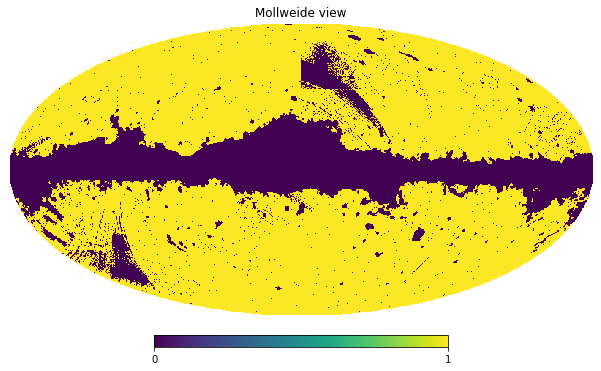

In [8]:
# Reading the map and masks
planck_map = hp.read_map('/home/akozameh/cmblss/data/COM_CMB_IQU-smica_2048_R3.00_oe2.fits')
m_1 = hp.read_map('/home/akozameh/cmblss/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')
m_2 = hp.read_map('/home/akozameh/cmblss/data/COM_Mask_CMB-HM-Misspix-Mask-Int_2048_R3.00.fits')

# Convert masks to numpy arrays with boolean dtype
m_1 = np.array(m_1, dtype=bool)
m_2 = np.array(m_2, dtype=bool)

# Combine masks using AND (common mask + Odd-Even missing pixels)
combined_mask = m_1 & m_2

# Visualize the mask
hp.mollview(combined_mask)

In [9]:
# Writing the masks in a fit file
hp.write_map("combined_mask.fits", combined_mask, overwrite=True)



setting the output map dtype to [dtype('bool')]


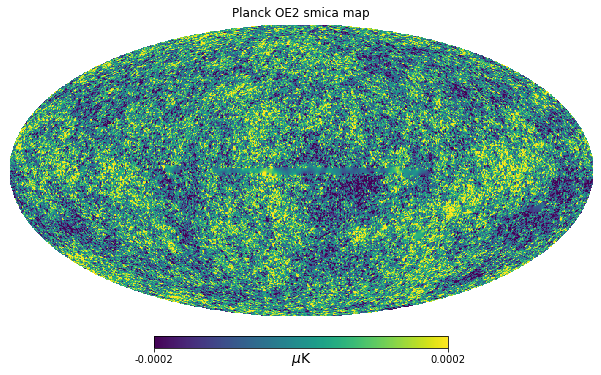

In [10]:
hp.mollview(planck_map, min=-200e-6, max=200e-6, title='Planck OE2 smica map', unit ='$\mu$K')     

In [11]:
# This step is for masking the CMB map
# Masked map
#mask=hp.read_map('/home/akozameh/cmblss/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')
mask_1=hp.read_map('/home/akozameh/cmblss/code/cmblss-main/combined_mask.fits')
smica_masked=hp.ma(planck_map)
smica_masked.mask=np.logical_not(mask_1)

In [12]:
# For better visualization purpses we mooth the map wit 1°
smica_masked=hp.smoothing(smica_masked, fwhm=(np.radians(1.0)))

In [13]:
# Estableshing the NSIDE
nside=1024
mask_1=hp.ud_grade(mask_1,nside)
planck_map=hp.ud_grade(planck_map, nside)

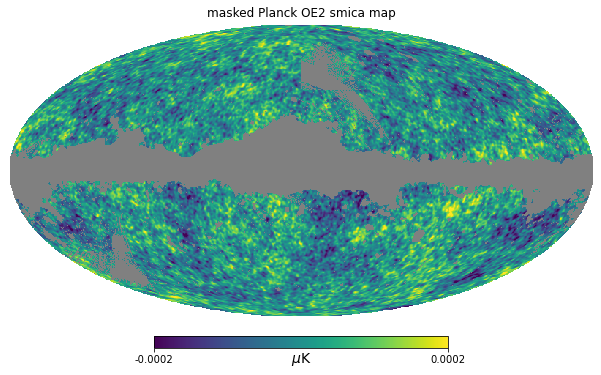

In [14]:
hp.mollview(smica_masked,min=-200e-6, max=200e-6, title='masked Planck OE2 smica map', unit ='$\mu$K')

### In this part I set the horizons whose coordinates are 345  and  15 degrees in longitude and latitude respectively, with a radius of 60 degrees.


In [16]:
# I set the horizon size for our analysis
longitude_1=345 # In degrees
latitude_1=15 # In degrees

longitude_1_rad=np.radians(longitude_1)
latitude_1_rad=np.radians(latitude_1)
colalitude_rad=np.pi/2 - latitude_1_rad

# I am going to set the horizons for our analysis"

vec_1=hp.ang2vec(colalitude_rad, longitude_1_rad)

# We set of the disc at 60 degrees to perform our analysis
radius=np.radians(60.)
disc_1=hp.query_disc(nside,vec_1,radius)

In [17]:
# Create a disc mask with zeros outside the disc
disc_mask_1 = np.zeros(hp.nside2npix(nside), dtype=bool)
disc_mask_1[disc_1] = True

In [18]:
# Combine the disc masks with the final mask
f_mask=disc_mask_1 & mask_1

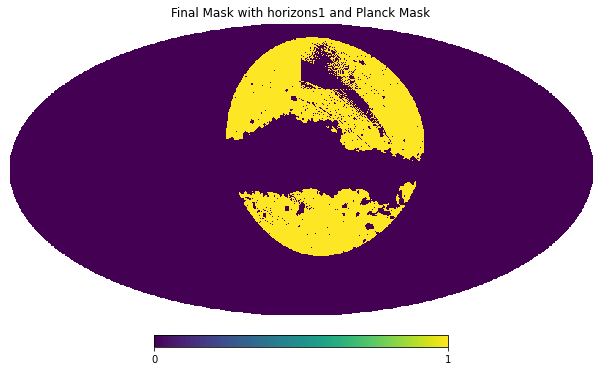

In [19]:
# Visualize the final mask
hp.mollview(f_mask, title="Final Mask with horizons1 and Planck Mask")
plt.show()

$f_{sky}$ is the effective are of the CMB sky for our analysis

 This will be used when we estimate the $\Delta C_{\ell}$ for our power spectrum for the selected horizons

In [20]:
# Calculate f_sky
f_sky = np.sum(f_mask) / len(f_mask)

print(f'f_sky = {f_sky}')

f_sky = 0.1471858819325765


In [21]:
# Apply the mask to the CMB map
masked_planck_map_1 = hp.ma(planck_map)
masked_planck_map_1.mask = np.logical_not(f_mask)

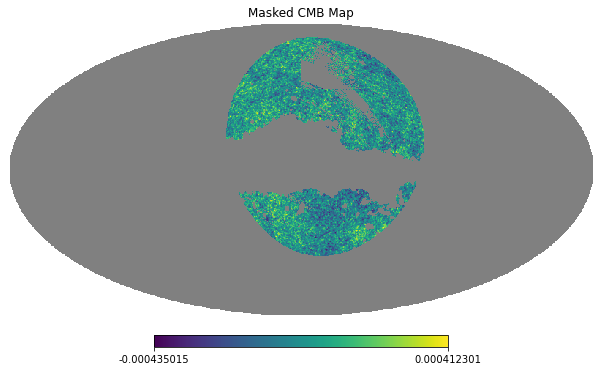

In [22]:
# Visualize the masked CMB map
hp.mollview(masked_planck_map_1, title="Masked CMB Map")
plt.show()

### Computing the Pseudo - $C_{\ell s}$ for our Horizont using NaMaster (Alonso et al. 2018)

Following Planck papers, we compute the pseudo-Dls in band powers  with $ \Delta \ell = 30$,
so that off-diagonal elements of the covariance matrix are kept
at the ∼ 10% level for the full Planck footprint (and some-
what larger for smaller patches),

In [46]:
# Compute Cls using NaMaster
f_0 = nmt.NmtField(f_mask, [masked_planck_map_1])
# Initialize binning scheme with 10 ells per bandpower for decreasing the noise.
b = nmt.NmtBin.from_nside_linear(nside, 30)

In [47]:
# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

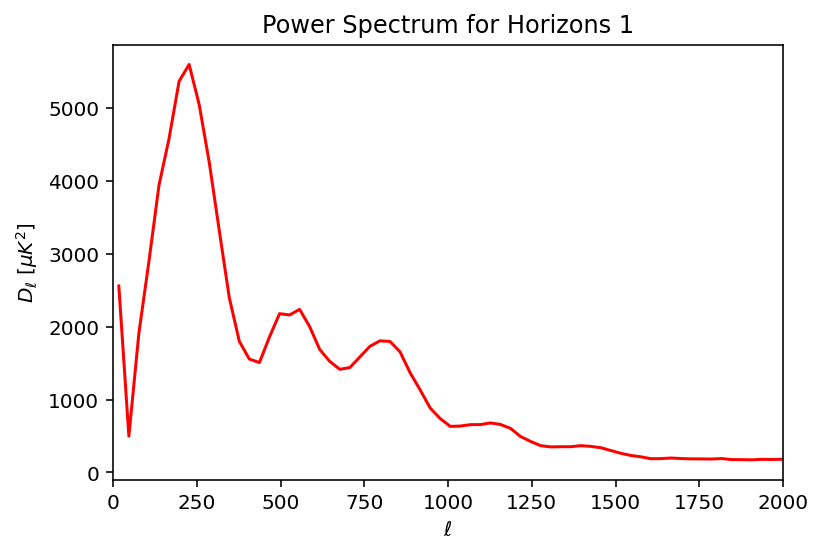

In [48]:
# Plot results

el = b.get_effective_ells()
Dl = cl_00[0]*el*(el+1)*[(1e6)**(2)]/2/np.pi
plt.plot(el,Dl, 'r-', label='TT for horizons 1 ')
plt.xlabel('$\ell$')
plt.xlim(0,2000)
plt.ylabel(r'$D_\ell~[\mu K^2]$')
plt.title('Power Spectrum for Horizons 1')
plt.show()

In [49]:
Dl.shape

(102,)

Reading the documentation of the Planck smica release we see that the output has a resolution of 10 minutes.Therefore as a first order correction of the beam, then we can divide the power spectrum by the gauss beam window function. I compute the spherical transform of a aximmetric gaussian beam with hp.gauss_beam

In [50]:
# Define the FWHM for the Planck SMICA beam (10 arcminutes)
fwhm_arcmin = 10
fwhm_rad = np.radians(fwhm_arcmin / 60.0)  # Convert to radians

# Compute the Gaussian beam window function using healpy
beam_window = hp.gauss_beam(fwhm_rad, lmax=np.max(el))

# Apply the correction: Divide the power spectrum by the beam window function squared
Dl_corrected = Dl / beam_window[:len(el)]**2

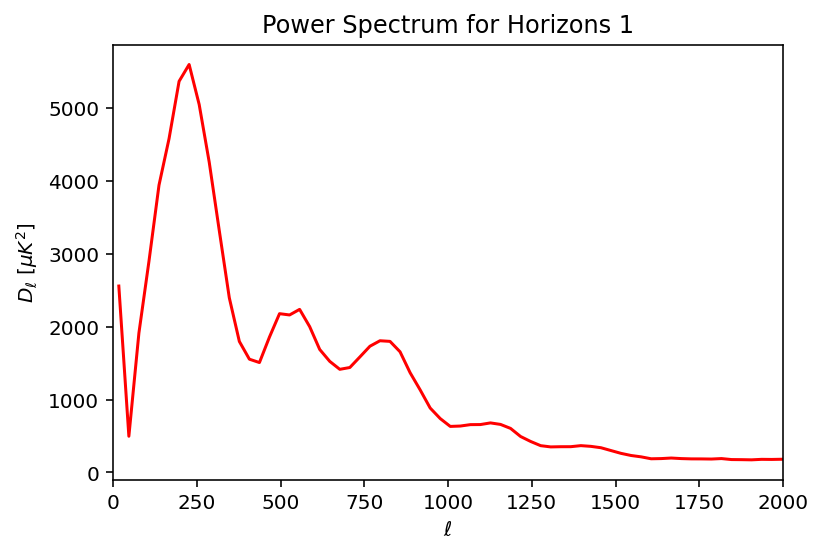

In [51]:
# Plot results


plt.plot(el,Dl_corrected, 'r-', label='TT for horizons 1 ')
plt.xlabel('$\ell$')
plt.xlim(0,2000)
plt.ylabel(r'$D_\ell~[\mu K^2]$')
plt.title('Power Spectrum for Horizons 1')
plt.show()

In [43]:
el

array([   6.5,   16.5,   26.5,   36.5,   46.5,   56.5,   66.5,   76.5,
         86.5,   96.5,  106.5,  116.5,  126.5,  136.5,  146.5,  156.5,
        166.5,  176.5,  186.5,  196.5,  206.5,  216.5,  226.5,  236.5,
        246.5,  256.5,  266.5,  276.5,  286.5,  296.5,  306.5,  316.5,
        326.5,  336.5,  346.5,  356.5,  366.5,  376.5,  386.5,  396.5,
        406.5,  416.5,  426.5,  436.5,  446.5,  456.5,  466.5,  476.5,
        486.5,  496.5,  506.5,  516.5,  526.5,  536.5,  546.5,  556.5,
        566.5,  576.5,  586.5,  596.5,  606.5,  616.5,  626.5,  636.5,
        646.5,  656.5,  666.5,  676.5,  686.5,  696.5,  706.5,  716.5,
        726.5,  736.5,  746.5,  756.5,  766.5,  776.5,  786.5,  796.5,
        806.5,  816.5,  826.5,  836.5,  846.5,  856.5,  866.5,  876.5,
        886.5,  896.5,  906.5,  916.5,  926.5,  936.5,  946.5,  956.5,
        966.5,  976.5,  986.5,  996.5, 1006.5, 1016.5, 1026.5, 1036.5,
       1046.5, 1056.5, 1066.5, 1076.5, 1086.5, 1096.5, 1106.5, 1116.5,
      

## This section corresponds with the exploration of cosmological parameters using  a code for
Iminuit is a code for maximum-likelihood fits of statistical models to data that
also provides model parameter errors from likelihood profile
estimation. 

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.5.7 installed at /home/akozameh/miniconda3/envs/CMB/lib/python3.10/site-packages/camb


In [30]:
from iminuit import Minuit
from iminuit.cost import LeastSquares

Compute the theoretical power spectrum. For these purposes we follow the Planck results 2018 (Aghanim et al. 2018) for cosmological parameters.

In [84]:
# Hypothetical function to compute the theoretical power spectrum
def theoretical_Cls(H0, ombh2, omch2, mnu, omk, tau, As, ns, lmax):
    # Set up a new set of parameters for CAMB
    pars = camb.set_params(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau,  
                           As=As, ns=ns, lmax=lmax)
    # Ensure lmax is an integer
    lmax = int(lmax)
    print(pars)
    # Calculate results for these parameters
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    totCL = powers['total']  # Get the total power spectrum (including lensed scalar)

    # Extract the theoretical power spectrum (Dl_th)
    Dl_th = totCL[:, 0]  # TT spectrum is the first column

    # Get the corresponding ell values
    ells = np.arange(0, lmax + 1)
    
    return ells, Dl_th

# Define cosmological parameters and lmax
lmax = 2000
H0 = 67.4
ombh2 = 0.0224
omch2 = 0.120
mnu = 0.06
omk = 0.0
tau =  0.054
As = 2e-9
ns = 0.965

# Compute the theoretical power spectrum
ells, Dl_th = theoretical_Cls(H0, ombh2, omch2, mnu, omk, tau, As, ns, lmax)

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2150
 max_l_tensor = 600
 max_eta_k = 5375.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0224
 omch2 = 0.12
 omk = 0.0
 omnuh2 = 0.000644866570625114
 H0 = 67.4
 TCMB = 2.7255
 YHe = 0.24586829360147697
 num_nu_massless = 2.0293333333333337
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0146666666666666]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.965
   nrun =

$$\ell $$

In [76]:
l=np.arange(len(Dl_th))

In [77]:
el

array([  16.5,   46.5,   76.5,  106.5,  136.5,  166.5,  196.5,  226.5,
        256.5,  286.5,  316.5,  346.5,  376.5,  406.5,  436.5,  466.5,
        496.5,  526.5,  556.5,  586.5,  616.5,  646.5,  676.5,  706.5,
        736.5,  766.5,  796.5,  826.5,  856.5,  886.5,  916.5,  946.5,
        976.5, 1006.5, 1036.5, 1066.5, 1096.5, 1126.5, 1156.5, 1186.5,
       1216.5, 1246.5, 1276.5, 1306.5, 1336.5, 1366.5, 1396.5, 1426.5,
       1456.5, 1486.5, 1516.5, 1546.5, 1576.5, 1606.5, 1636.5, 1666.5,
       1696.5, 1726.5, 1756.5, 1786.5, 1816.5, 1846.5, 1876.5, 1906.5,
       1936.5, 1966.5, 1996.5, 2026.5, 2056.5, 2086.5, 2116.5, 2146.5,
       2176.5, 2206.5, 2236.5, 2266.5, 2296.5, 2326.5, 2356.5, 2386.5,
       2416.5, 2446.5, 2476.5, 2506.5, 2536.5, 2566.5, 2596.5, 2626.5,
       2656.5, 2686.5, 2716.5, 2746.5, 2776.5, 2806.5, 2836.5, 2866.5,
       2896.5, 2926.5, 2956.5, 2986.5, 3016.5, 3046.5])

##### In this subsections we are going to interpolated our $pseudo_{dls}$

Following the procedure to avoid residuals contamination at low $\ell$ and high $\ell$by Gaztañaga & Fosalba, our $l_{min}=30$ and $l_{max}=2000$  

In [78]:
from scipy.interpolate import interp1d
f=interp1d(el, Dl_corrected, kind='nearest') # My function to interpolation 

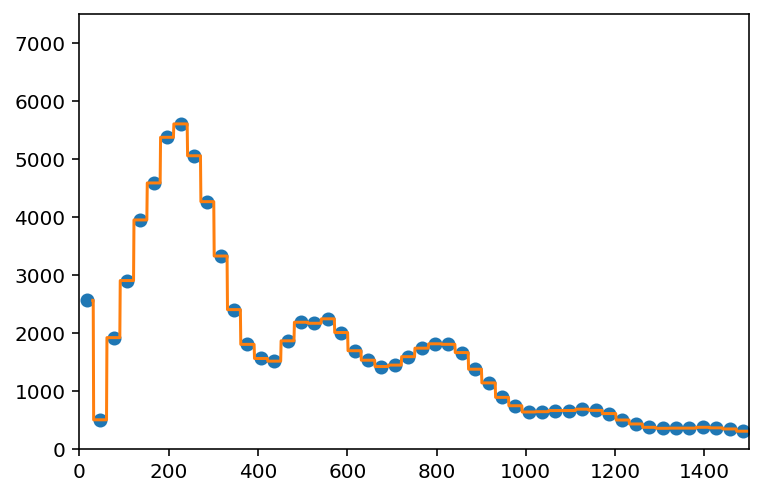

In [79]:
l_new=np.linspace(30, 2000, 2051) # Adjust as needed
estimated_Dl=f(l_new)
plt.plot(el, Dl_corrected, 'o', l_new, estimated_Dl, '-')
plt.xlim(0,1500)
plt.ylim(0,7500)
plt.show()

#### This subsection I compute errors for the power spectrum 

I am going to compute the errors of $pseudo (C_\ell).$ The approach we are going to use is to assume that the errors are dominated by cosmic variance. Thus:

In [80]:
from IPython.display import display, Math
display(Math(r'\sigma(C_{\ell})= \sqrt{\frac{2}{(2l+1)f_{sky}}} \cdot C_{\ell}'))

<IPython.core.display.Math object>

Where the Where  𝐶ℓ are my pseudo power spectrum,  

𝑓𝑠𝑘𝑦 is fraction of our sky for analysis,

$\ell$ are the binned multipoles for our analysis.

In [81]:
Dl_err = np.sqrt(2 / ((2*l + 1)*f_sky))*estimated_Dl

In [82]:
Dl_diff = estimated_Dl - Dl_th[:len(estimated_Dl)]# Ensure both arrays have the same length

Text(0.5, 1.0, 'Residual differences between experimental and Theoretical Power Spectrums of CMB')

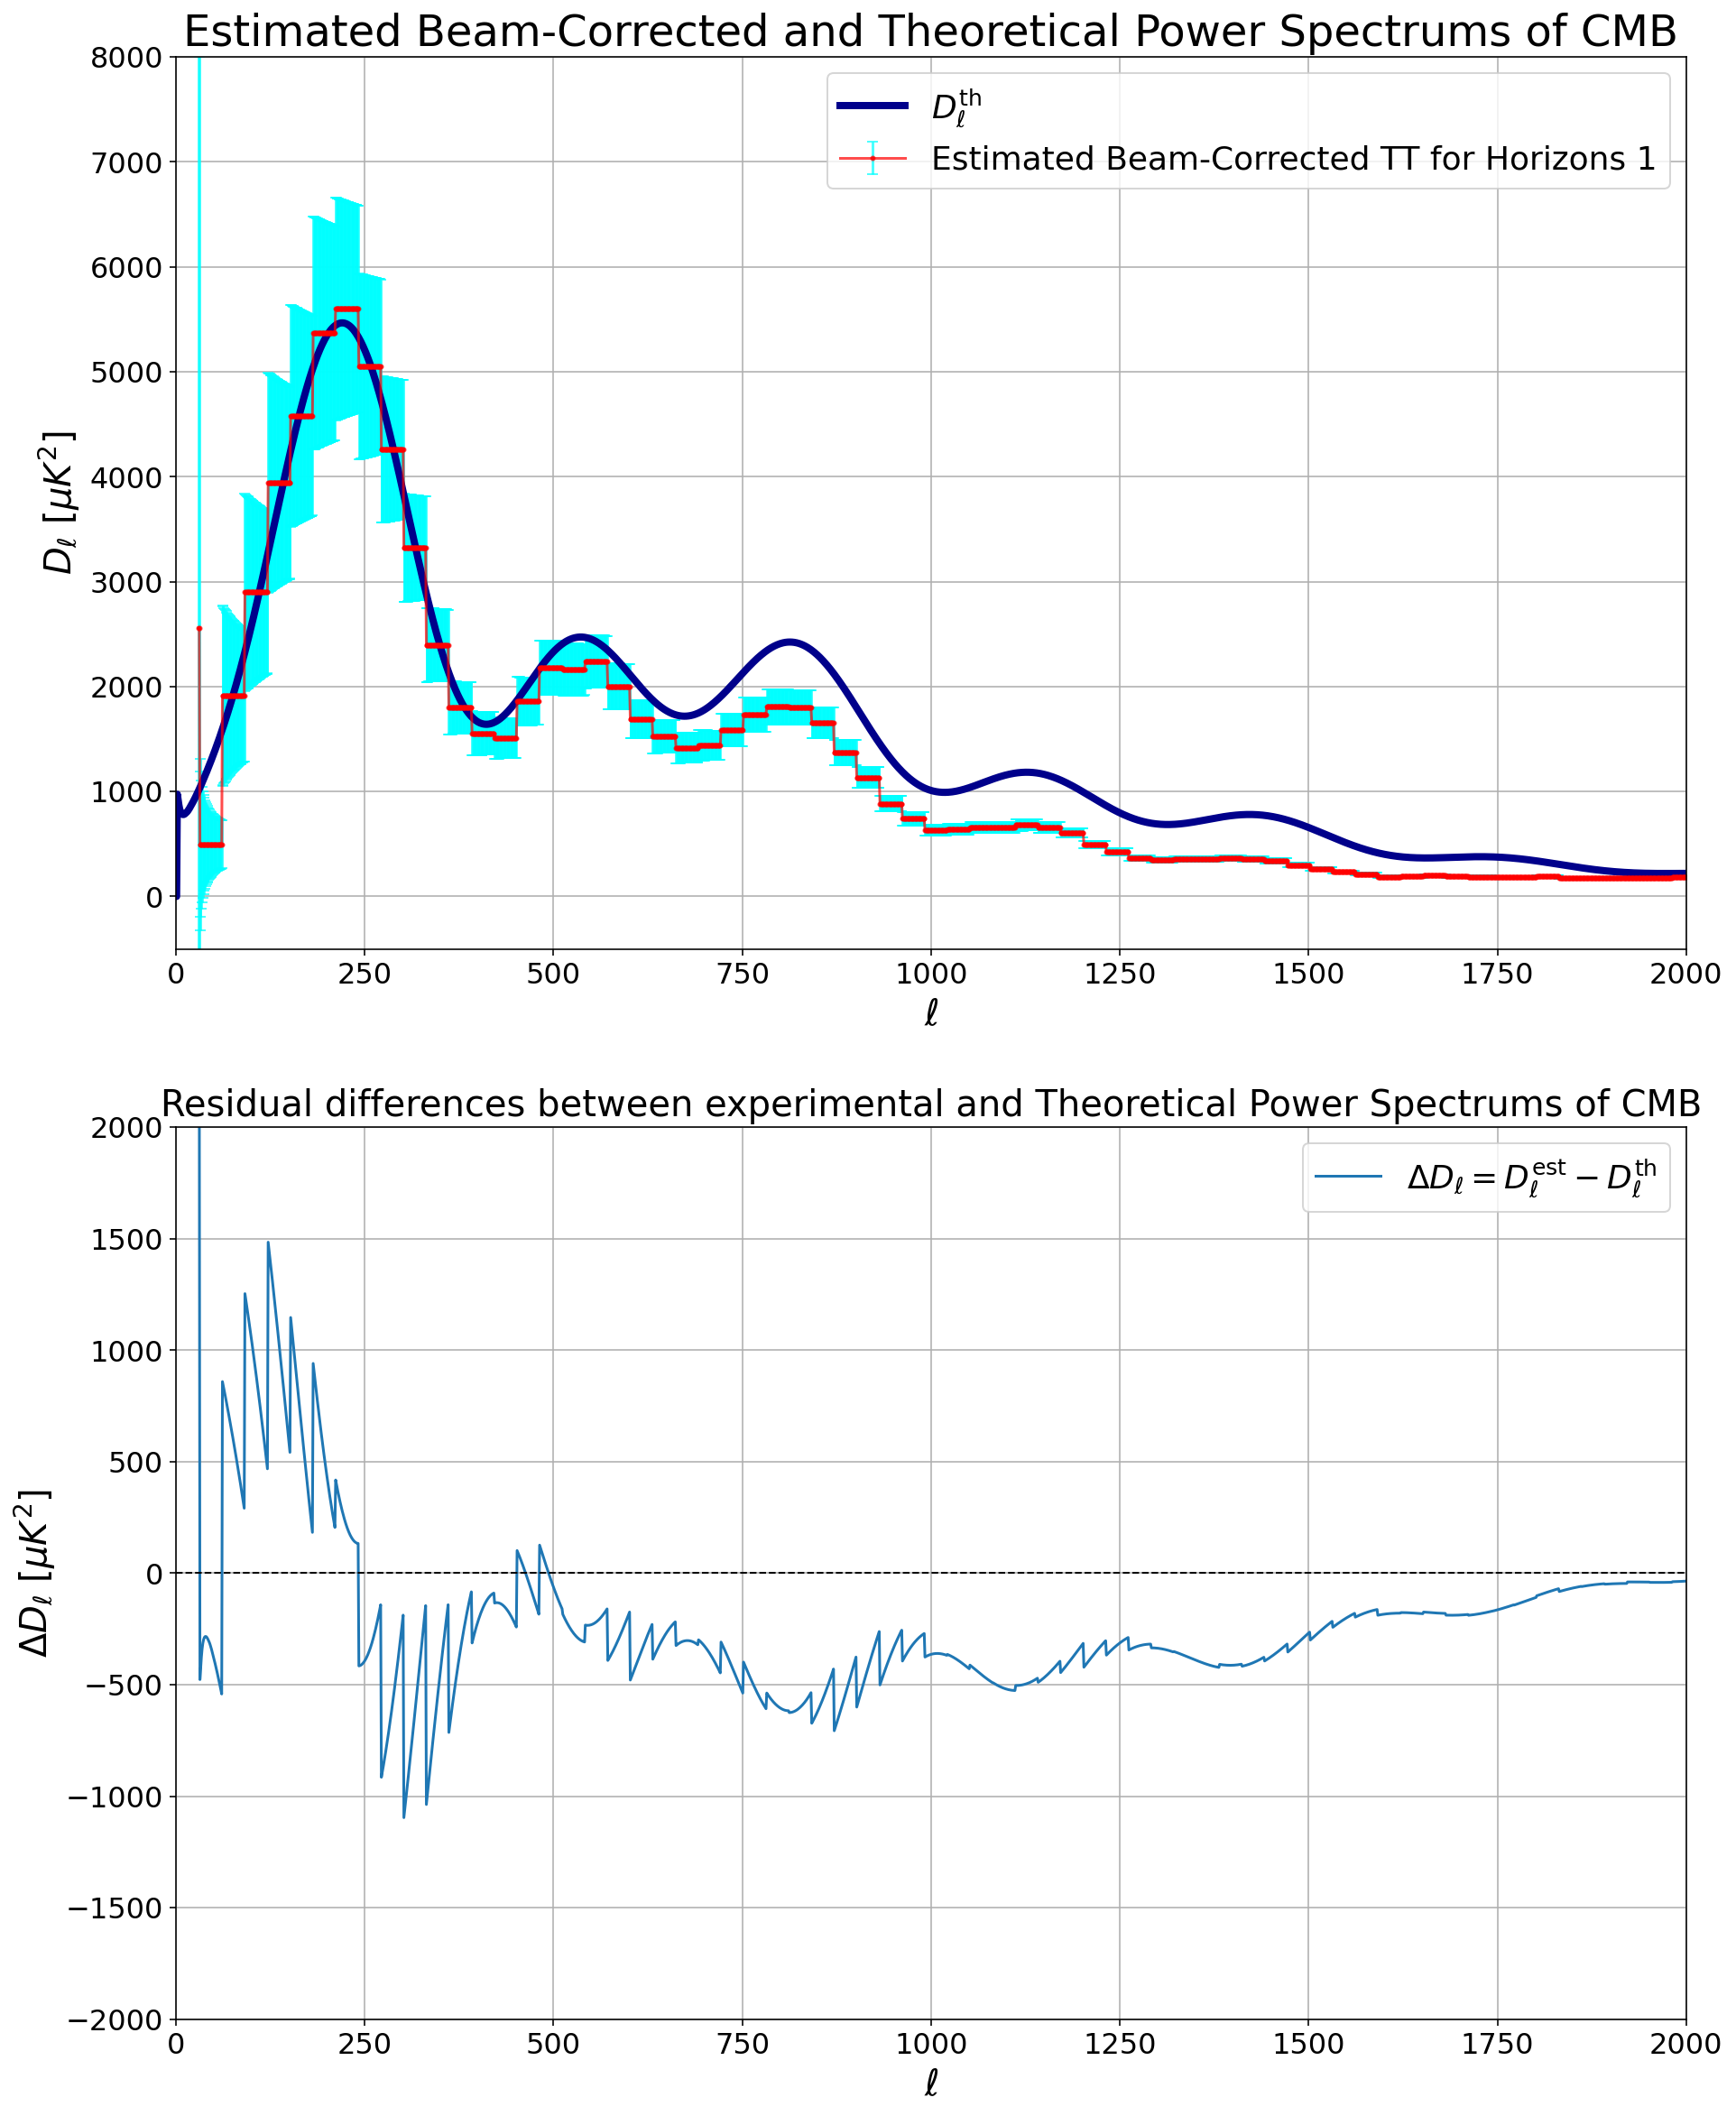

In [83]:
# Plotting together
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 20))

#fig.suptitle('Estimated Beam-Corrected and Theoretical Power Spectrums of CMB and its differences with respect to l', fontsize=12)
# Errobar plot
ax1.errorbar(l_new, estimated_Dl, 
    yerr=Dl_err, 
    fmt='ro-',           # Change color to red and use small circles for points
    ecolor='cyan',          # Error bars will be red
    capsize=3,           # Set the size of the caps on the error bars
    alpha=0.7,           # Set transparency to 70%
    markersize=2,        # Decrease the size of the markers
    label='Estimated Beam-Corrected TT for Horizons 1')
# Theorethical plot
ax1.plot(l, Dl_th, 
    linewidth=4,
    label=r'$D_\ell^{\mathrm{th}}$', 
    color='darkblue'
)
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_xlim(0, 2000)
ax1.set_ylim(-500, 8000)  # Adjust the y-axis as needed
ax1.tick_params(axis='both', which='major', labelsize=16)

ax1.set_ylabel(r'$D_\ell~[\mu K^2]$', fontsize=20)
ax1.grid(True)
ax1.legend(fontsize=18)
ax1.set_title('Estimated Beam-Corrected and Theoretical Power Spectrums of CMB', fontsize=24)

# Residual differences plot
             
ax2.plot(l_new, Dl_diff, label=r'$\Delta D_\ell = D_\ell^{\mathrm{est}} - D_\ell^{\mathrm{th}}$')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  # Add a horizontal line at y=0
ax2.set_xlabel(r'$\ell$', fontsize=20)
ax2.set_ylabel(r'$\Delta D_\ell~[\mu K^2]$', fontsize=20)
ax2.set_xlim(0, 2000)
ax2.set_ylim(-2000, 2000)  # Adjust the y-axis as needed
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.grid(True)
ax2.legend(fontsize=18)
ax2.set_title('Residual differences between experimental and Theoretical Power Spectrums of CMB', fontsize=20)

As we can see, we have obtained  the power spectrum of the horizon with centre at longitude=345 and latitude=15 (galactic coordinates) and radius $60°$.Our power spectrum and  the theoretical CMB power spectrum got by CAMB (Lewis. et al 2006), using as input the cosmological parameters obtained by Planck collaboration (Aghanim. et al 2018), well match until $\ell \approx 700$ multipoles. This is discrepance with the reported in (Fosalba & Gaztañaga, 2022) where the theoretical and experimental power spectrum match at all $\ell$. One posible source of the discrepancy at high $\ell$ may be due to a inhomogeneus patchy of reinization that vary the optical depth, $\tau$. This inhomogeneus reinization may be produce an additional damping on low scales (high $\ell$).   

## This sections is about to realize the parameter exploration using iminuit

In [85]:
# Importing iminuit
from iminuit import Minuit
from iminuit.util import make_func_code
from scipy.stats import chi2

In [86]:
# Example chi-square function (to be replaced with your actual calculation)
def chi2_func(H0, ombh2, omch2, ns, As, tau, omk, mnu, lmax):
    Dl_model = theoretical_Cls(H0=H0, ombh2=ombh2, omch2=omch2, ns=ns, As=As, tau=tau, omk=omk, mnu=mnu, lmax=lmax)
    Dl_th=Dl_model
    return np.sum((estimated_Dl - Dl_th)**2 / Dl_err **2) 

In [87]:
# Initial guesses for cosmological parameters
initial_guesses = {
    'H0': 67.4,
    'ombh2': 0.0221,
    'omch2': 0.121,
    'ns': 0.963,
    'As': 2.09e-9,
    'tau': 0.06,
    'omk': 0.0,
    'mnu': 0.06,
    'lmax': 2000,
}

# Set parameter limits
parameter_limits = {
    'H0': (66.1, 90.0),
    'ombh2': (0.0215, 0.0300),
    'omch2': (0.100, 0.200),
    'ns': (0.9600, 0.9700),
    'As': (1.0e-9, 4e-9),
}

In [88]:
# Create the Minuit object
minimizer = Minuit(chi2_func, **initial_guesses)
for param, limits in parameter_limits.items():
    minimizer.limits[param] = limits

# Run the minimization
minimizer.migrad()

# Print the best-fit parameters and their uncertainties
print("Best-fit parameters:")
for param in initial_guesses.keys():
    print(f"{param} = {minimizer.values[param]} ± {minimizer.errors[param]}")

# Extract the covariance matrix
cov_matrix = minimizer.covariance

# Plot the confidence ellipses for pairs of parameters (e.g., H0 vs. ombh2)
def plot_confidence_ellipse(cov_matrix, param1, param2, minimizer, ax=None, n_std=1.0, **kwargs):
    import matplotlib.transforms as transforms
    from matplotlib.patches import Ellipse

    if ax is None:
        ax = plt.gca()

    mean = [minimizer.values[param1], minimizer.values[param2]]
    cov = cov_matrix[(param1, param2)]

    pearson = cov / np.sqrt(cov_matrix[(param1, param1)] * cov_matrix[(param2, param2)])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor='none', **kwargs)

    scale_x = np.sqrt(cov_matrix[(param1, param1)]) * n_std
    scale_y = np.sqrt(cov_matrix[(param2, param2)]) * n_std

    transf = (transforms.Affine2D()
              .rotate_deg(45)
              .scale(scale_x, scale_y)
              .translate(mean[0], mean[1]))

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

# Example plot for H0 vs. ombh2
fig, ax = plt.subplots()
ax.errorbar(minimizer.values['H0'], minimizer.values['ombh2'],
            xerr=minimizer.errors['H0'], yerr=minimizer.errors['ombh2'],
            fmt='o', color='red', label='Best-fit')

plot_confidence_ellipse(cov_matrix, 'H0', 'ombh2', minimizer, ax=ax, edgecolor='blue', n_std=1)
plot_confidence_ellipse(cov_matrix, 'H0', 'ombh2', minimizer, ax=ax, edgecolor='green', n_std=2)

ax.set_xlabel('H0')
ax.set_ylabel('ombh2')
ax.set_title('Confidence Ellipses for H0 and ombh2')
plt.legend()
plt.grid()
plt.show()


TypeError: 'numpy.float64' object cannot be interpreted as an integer